In [ ]:
import torch
import json
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from lbfgs import FullBatchLBFGS
from utils import reparametrized_expanded_params, init_random_params, save_objects_to_yaml, convert_to_yaml

### Loading the French Parliament Dataset

#### Dataset Overview
The dataset used in this study represents voting patterns in the French parliament. It consists of three key components:
1. **Votes Matrix**: A binary matrix where rows correspond to Members of Parliament (MPs), and columns correspond to ballots. Each entry in the matrix indicates whether an MP voted "YES" (1) or "NO" (-1). Abstentions and absences are treated as missing values (0).
2. **Deputies Metadata**: A JSON file containing metadata about each MP, including their political affiliation and other relevant details.
3. **Texts Metadata**: A JSON file with descriptions of each ballot topic, providing context about the nature of the votes.

The goal is to preprocess and visualize the dataset to better understand the patterns of voting behavior, party alignments, and clustering tendencies.

#### Visualization Goals
We will perform the following tasks to analyze the dataset:
- Inspect the **Votes Matrix** to explore voting behavior.
- Visualize the distribution of missing votes (abstentions/absences).
- Analyze metadata to identify trends in party affiliations and their voting alignments.

In [4]:
##############" LOADING DATASET" ################

votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)
deputes = json.load(open('data_parliament/deputes.json', 'r'))
texts = json.load(open('data_parliament/texts.json', 'r'))
n1, n2 = votes.shape
nq, nl = 3, 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Votes matrix dimensions: 576 MPs x 1256 ballots
Number of MPs (Rows): 576
Number of Ballots (Columns): 1256


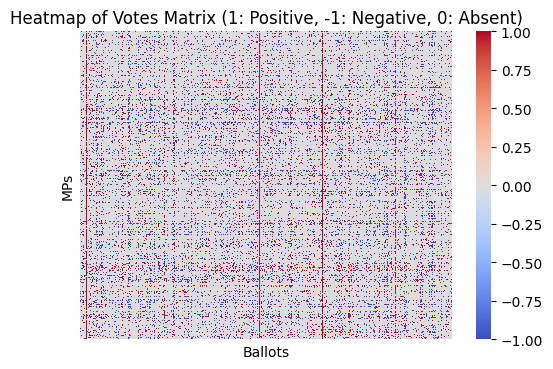

In [22]:
# Displaying basic information about the dataset
n1, n2 = votes.shape
print(f"Votes matrix dimensions: {n1} MPs x {n2} ballots")
print(f"Number of MPs (Rows): {n1}")
print(f"Number of Ballots (Columns): {n2}")

# Visualizing the Votes Matrix with appropriate mapping for 1, -1, and 0
plt.figure(figsize=(6, 4))
sns.heatmap(votes, cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Heatmap of Votes Matrix (1: Positive, -1: Negative, 0: Absent)")
plt.xlabel("Ballots")
plt.ylabel("MPs")
plt.show()

The distribution of red, blue, and white indicates the participation and alignment of MPs during various ballots. Clusters in the matrix may suggest patterns in political alliances or topic-based voting tendencies.

Total positive votes: 42820
Total negative votes: 61832
Total absent votes: 618804


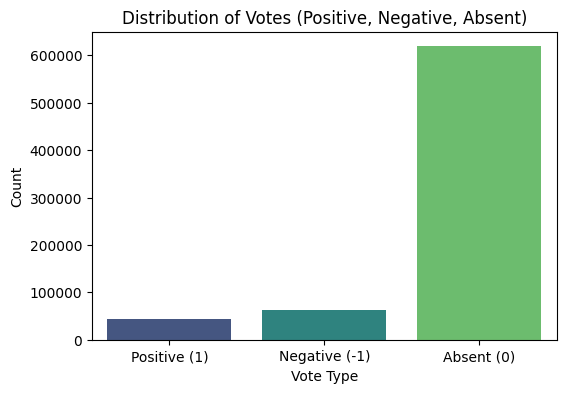

In [29]:
# Count of votes (Positive, Negative, Absent)
positive_votes = (votes == 1).sum()
negative_votes = (votes == -1).sum()
absent_votes = (votes == 0).sum()

print(f"Total positive votes: {positive_votes}")
print(f"Total negative votes: {negative_votes}")
print(f"Total absent votes: {absent_votes}")

# Visualizing the distribution of positive, negative, and absent votes
vote_counts = [positive_votes, negative_votes, absent_votes]
vote_labels = ["Positive (1)", "Negative (-1)", "Absent (0)"]

plt.figure(figsize=(6, 4))
sns.barplot(x=vote_labels, y=vote_counts, palette="viridis", hue=vote_labels)
plt.title("Distribution of Votes (Positive, Negative, Absent)")
plt.xlabel("Vote Type")
plt.ylabel("Count")
plt.show()

This bar chart highlights the overall distribution of votes:
- **Positive votes (1)**: 42,820.
- **Negative votes (-1)**: 61,832.
- **Absent votes (0)**: 618,804.

The majority of votes are marked as absent, indicating significant non-participation. This highlights the importance of addressing absenteeism in understanding parliamentary behavior.

Unique political affiliations: {'LaREM', 'LT', 'GDR', 'LR', 'FI', 'SOC', 'UDI-AGIR', 'MODEM', 'NI'}


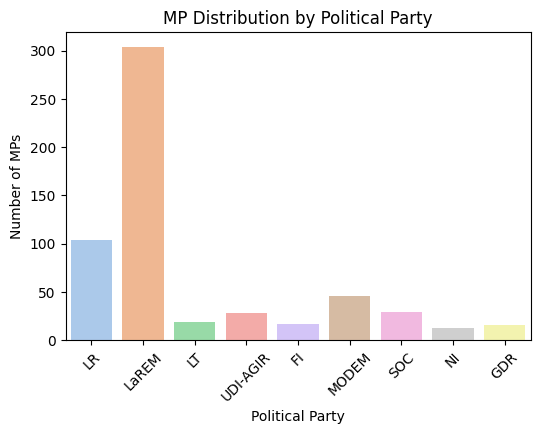

In [28]:
# Summarizing metadata for political affiliations
political_affiliations = [mp["groupe"] for mp in deputes]
unique_parties = set(political_affiliations)
print(f"Unique political affiliations: {unique_parties}")

# Party-wise MP distribution
from collections import Counter
party_distribution = Counter(political_affiliations)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(party_distribution.keys()), y=list(party_distribution.values()), palette="pastel", hue=list(party_distribution.keys()))
plt.title("MP Distribution by Political Party")
plt.xticks(rotation=45)
plt.xlabel("Political Party")
plt.ylabel("Number of MPs")
plt.show()


This bar chart represents the number of MPs belonging to each political party:
- The largest group is **LaREM (La République En Marche)** with over 300 MPs.
- Other significant parties include **LR (Les Républicains)** and **MODEM**.
- Smaller parties, such as **GDR**, **FI**, and **LT**, also contribute to the dataset.

This distribution shows the dominance of government-affiliated parties and the fragmentation of opposition groups.

### Model initialization

# Model Initialization and Creation

### Objective
The goal is to initialize the parameters and create a Latent Block Model (LBM) with a Missing Not At Random (MNAR) missingness mechanism. This model leverages missing data as an informative component to cluster MPs (rows) and ballots (columns) in the French parliamentary dataset.

### Notations
- $n_1, n_2$: Number of rows (MPs) and columns (Ballots).
- $K, L$: Number of row and column clusters, respectively.
- $\mathbf{X}^{(o)}$: Observed data matrix with entries in $\{0, 1, \text{NA}\}$.
- $\mathbf{M}$: Binary mask matrix indicating observed entries.
- $\alpha, \beta$: Mixture proportions for row and column clusters.
- $\pi_{kl}$: Probability of observing a 1 in block $(k, l)$.
- $A_i, B_i, C_j, D_j$: Latent variables modeling row- and column-level effects for missingness following gaussian law with zero means and variance $\sigma^2$.
- $\mu$: Global missingness propensity parameter.

### Model Framework
1. **Binary Latent Block Model**: 
   - Each entry $X_{ij} \mid Y_{ik}=1, Z_{jl}=1 \sim \mathcal{B}(\pi_{kl})$, where $Y_i$ and $Z_j$ are row and column cluster memberships.
   - Row clusters $Y_i \sim \mathcal{M}(1, \alpha)$ and column clusters $Z_j \sim \mathcal{M}(1, \beta)$.
2. **Missingness Mechanism (MNAR)**: Missingness depends on latent variables and observed values. The missingness probability is modeled as:
   $$
   P(M_{ij} = 1) = \text{expit}(\mu + A_i + C_j + B_i \cdot X_{ij} + D_j \cdot (1 - X_{ij})),
   $$
   where $\text{expit}(x) = \frac{1}{1 + e^{-x}}$.


#### Model Initialization
To train the model:
1. **Latent Parameters**: We initialize the latent parameters $\theta = (\alpha, \beta, \pi, \mu, \sigma_A^2, \sigma_B^2, \sigma_C^2, \sigma_D^2)$ and define the model:
2. **Optimization Framework**: The model parameters are set to `requires_grad=True` to enable gradient-based optimization (e.g., stochastic gradient descent).

### Code Explanation
- `init_random_params(n1, n2, nq, nl)`: Randomly initializes the latent parameters $ \theta $ based on the specified number of clusters and matrix dimensions.
- `LBM_NMAR`: The Latent Block Model with MNAR assumption is instantiated using the initialized parameters, votes matrix, and cluster configurations.



In [6]:
##############" Init and creating model " ################
vector_of_parameters = torch.tensor(
    init_random_params(n1, n2, nq, nl), requires_grad=True, device=device
)

model = LBM_NMAR(
    vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device
)

print("Model Initialized")

Model Initialized


### Model training

#### Objective
This section outlines the training process for the Latent Block Model (LBM) with MNAR missingness. The training optimizes the model parameters using the LBFGS algorithm, aiming to maximize the likelihood function while ensuring the model's convergence. The parameters are re-parameterized for interpretability and numerical stability.


#### Training Process
1. **Optimization Algorithm**:
   - The training uses the LBFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) optimizer, a quasi-Newton optimization method suitable for large-scale problems.
   - The algorithm alternates between optimizing by using the Variational EM algorithm:
     - **Model parameters**: $\theta$ (e.g., $\mu$, $\pi$, $\sigma^2$, etc.).
     - **Variational parameters**: $\gamma$ (e.g., cluster memberships).

2. **Stopping Criteria**:
   - Convergence is determined by:
     - Change in log-likelihood below a threshold ($10^{-3}$).
     - Gradient norm below a tolerance level ($10^{-4}$).

3. **Objective Function**:
   - The objective function is the negative log-likelihood, combining both the clustering model and missingness mechanism.

4. **Re-parameterization**:
   - Parameters are re-parameterized (e.g., via softmax, sigmoid) for numerical stability and interpretability.

See Annex for more in-depth explanation of the optimization algorithm and the Re-parametrization. For the V-EM one can refer to the report present in the repository of this work.

In [3]:
try:
    success, loglike = train_with_LBFGS(model)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

# Parameters of the model
(
    nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)


-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  3
Number of col classes :  5
 EM step  |   LBFGS iter  | criteria |


/content/lbfgs.py:339: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  p.data.add_(


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 118  |   250  | 269396.04353 |
 118  |   251  | 269396.04021 |
 118  |   252  | 269396.03663 |
 118  |   253  | 269396.03391 |
 118  |   254  | 269396.03119 |
 118  |   255  | 269396.02896 |
 118  |   256  | 269396.02635 |
 118  |   257  | 269396.02402 |
 118  |   258  | 269396.02242 |
 118  |   259  | 269396.02016 |
 118  |   260  | 269396.01903 |
 118  |   261  | 269396.01722 |
 118  |   262  | 269396.01606 |
 118  |   263  | 269396.01413 |
 118  |   264  | 269396.01315 |
 118  |   265  | 269396.01107 |
 118  |   266  | 269396.00980 |
 118  |   267  | 269396.00743 |
 118  |   268  | 269396.00615 |
 118  |   269  | 269396.00408 |
 118  |   270  | 269396.00273 |
 118  |   271  | 269396.00089 |
 118  |   272  | 269395.99862 |
 118  |   273  | 269395.99636 |
 118  |   274  | 269395.99325 |
 118  |   275  | 269395.98853 |
 118  |   276  | 269395.98304 |
 118  |   277  | 269395.97676 |
 118  |   278  | 269395.96

### Training Analysis

The following plot illustrates the evolution of the training loss during the optimization process:

![Training Loss](training_loss.png)

#### Training Progress
The optimization involved alternating steps of Expectation-Maximization (EM) and LBFGS, focusing on minimizing the negative log-likelihood.

#### Observations:
1. **Convergence Behavior**:
   - Each EM step performed multiple LBFGS iterations.
   - The criteria (log-likelihood value) generally decreased across iterations, showing steady progress toward convergence.
   - Occasional failed curvature pairs during the LBFGS optimization indicate potential issues with gradient stability, especially at step 507.

2. **Final Results**:
   - The log-likelihood plateaued after many iterations, suggesting the model reached a local minimum.
   - EM and LBFGS iterations were effective until the point where numerical instabilities began to appear (e.g., skipped curvature pairs in later iterations).

---

### Interpretation of Optimization Issues in Terms of the Loss Surface

#### 1. Sudden Drop in Log-Likelihood
- **Observation**: At step 507, there was a sudden drop in log-likelihood from $169,391.93 \to 141,274.85$. This behavior suggests potential instabilities in the optimization process.
  
- **Loss Surface Interpretation**:
  - **Flat Regions or Saddle Points**: The sudden drop indicates the optimizer might have encountered a **flat region** or **local saddle point** in the loss surface. These areas are characterized by small or unreliable gradients, leading to large, unstable steps.
  - **Reconfiguration of Latent Classes**: The Variational Expectation-Maximization (VEM) framework may have caused a shift in the latent class configuration. This can temporarily reduce the log-likelihood as the model transitions to a new parameter regime.
  - **Imbalance Between Terms**: The loss surface, derived from the **negative Evidence Lower Bound (ELBO)**, may have regions where the reconstruction term dominates the KL-divergence term (or vice versa), destabilizing the optimization.

- **Numerical Impact**:
  - The sharp drop may reflect **ill-conditioned gradients** caused by extreme parameter values (e.g., probabilities near $0$ or $1$, or variances close to $0$). This can make updates erratic and disrupt the optimizer's trajectory.

---

#### 2. Stopping Condition: `obj inf or <0`
- **Observation**: The optimization stopped with the message: `BFGS failed: obj inf or <0`. This indicates severe instability in the loss computation.

- **Loss Surface Interpretation**:
  - **Objective Approaching Infinity**:
    - This can occur if variational parameters diverge during optimization. For instance, extremely high or low values in the latent space can lead to numerical underflow or overflow in exponential/logarithmic calculations.

- **Shape of the Loss Surface**:
  - The negative ELBO often exhibits **sharp cliffs**, **plateaus**, or **ill-posed regions**, where:
    - **Sharp cliffs** lead to excessively large gradients, causing erratic parameter updates.
    - **Plateaus** result in vanishing gradients, stalling optimization.
    - **Ill-posed regions** with discontinuities or near-singular curvature challenge optimizers like BFGS, which rely on accurate second-order information.

---

#### Parameter Analysis

##### 1. **Class Proportions**:
- **Row classes**:
  $$
  \alpha_1 = \begin{bmatrix} 
  0.3889, & 0.4722, & 0.1389 
  \end{bmatrix}
  $$
- **Column classes**:
  $$
  \alpha_2 = \begin{bmatrix} 
  0.5355, & 0.1833, & 0.0311, & 0.1033, & 0.1468 
  \end{bmatrix}
  $$
- Class proportions represent the relative sizes of each latent class for rows and columns. The second row class dominates, while column classes are more distributed.

##### 2. **Pi Matrix**:
- $\pi$, representing block probabilities:
$$
\pi =
\begin{bmatrix}
0.8799 & 0.1819 & 0.2173 & 0.5227 & 0.0189 \\
0.1224 & 0.7203 & 0.9992 & 0.8081 & 0.9969 \\
0.1829 & 0.4968 & 0.9905 & 0.1975 & 0.9914 \\
\end{bmatrix}
$$
- Probabilities near $1$ indicate high interaction (e.g., $\pi_{22}$), while values near $0$ indicate low interaction (e.g., $\pi_{11}$).

##### 3. **Variance Terms**:
- Variances for different model components:
  - $\sigma^2_a = 1.94$
  - $\sigma^2_b = 3.42$
  - $\sigma^2_p = 2.24$
  - $\sigma^2_q = 1.44$

  These describe the spread of the model components:
  - $\sigma^2_a$, $\sigma^2_b$: Variances for row and column latent spaces.
  - $\sigma^2_p$, $\sigma^2_q$: Additional latent dimensions or structural variances.

##### 4. **Global Bias**:
- The global bias ($\mu_{un}$) is $18.58$, representing the general tendency across all interactions. It suggests strong positive baseline interactions.

In [7]:
#indices
indices_p = np.argwhere(votes == 1) #argwhere: matrix with couples (row,column) with 1 values
indices_n = np.argwhere(votes == -1) #idem with -1
indices_zeros = np.argwhere(votes == 0) #idem with 0

In [ ]:
# the code below save the model training outputs as a yaml file for reproducability
parameters_dict = {
    'n1': n1,
    'n2': n2,
    'nq': nq,
    'nl': nl,
    'nu_a':nu_a,
    'rho_a':rho_a,
    'nu_b':nu_b,
    'rho_b':rho_b,
    'nu_p': nu_p,
    'rho_p':rho_p,
    'nu_q':nu_q,
    'rho_q':rho_q,
    'tau_1':tau_1,
    'tau_2':tau_2,
    'mu_un':mu_un,
    'sigma_sq_a': sigma_sq_a,
    'sigma_sq_b':sigma_sq_b,
    'sigma_sq_p':sigma_sq_p,
    'sigma_sq_q':sigma_sq_q,
    'alpha_1':alpha_1,
    'alpha_2':alpha_2,
    'pi':pi,
    'indices_p': indices_p,
    'indices_n':indices_n,
    'indices_zeros': indices_zeros,
    'device': device
}

save_objects_to_yaml(parameters_dict, 'trained_parameters.yaml')

In [17]:
# loaded_parameters = load_objects_from_yaml('trained_parameters.yaml')
parameters_dict = {key: convert_to_yaml(obj) for key, obj in parameters_dict.items()}
n1 = parameters_dict['n1'] #number of rows
n2 = parameters_dict['n2'] #number of columns

nq = parameters_dict['nq'] #enter number of row classes
nl = parameters_dict['nl'] #enter number of column classes

pi = np.array(parameters_dict['pi'])

tau_1 = np.array(parameters_dict['tau_1'])
tau_2 = np.array(parameters_dict['tau_2'])
row_classes = tau_1.argmax(axis=1)
column_classes = tau_2.argmax(axis=1)

nu_a = np.array(parameters_dict['nu_a'])
nu_b = np.array(parameters_dict['nu_b'])
nu_c = np.array(parameters_dict['nu_p'])
nu_d = np.array(parameters_dict['nu_q'])

_, datafr = pol(column_classes, texts)

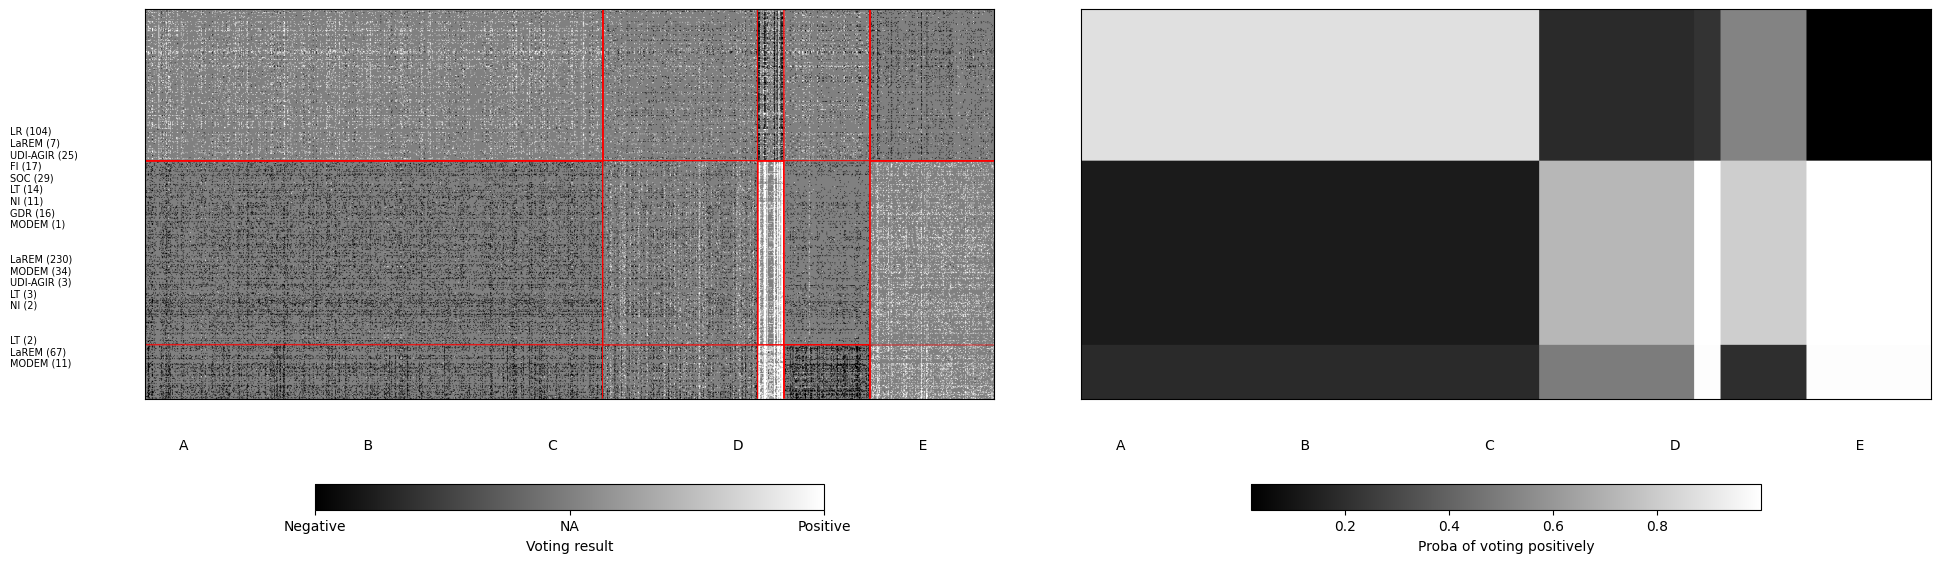

In [20]:
fig_17(votes, deputes, row_classes, column_classes, pi)

#### Observations:
- **MP Clustering:** 
    - MPs are grouped into three clusters:
        1. Opposition (SOC, LR, etc.).
        2. Government-aligned parties (LaREM, MODEM).
        3. A mixed cluster showing partial alignment between the opposition and government on some topics.
- **Ballot Clustering:** 
    - Ballots are divided into five topics (A to E):
        - **A:** Proposed by the opposition and largely opposed by the government.
        - **C and E:** Proposed by the government and positively voted on.
        - **D and B:** Show mixed voting patterns, with some government MPs aligning with opposition views.

#### Key Insights:
- Clear ideological divisions exist between the opposition and government-aligned parties.
- Ballots are primarily clustered based on their proposers' political affiliation.


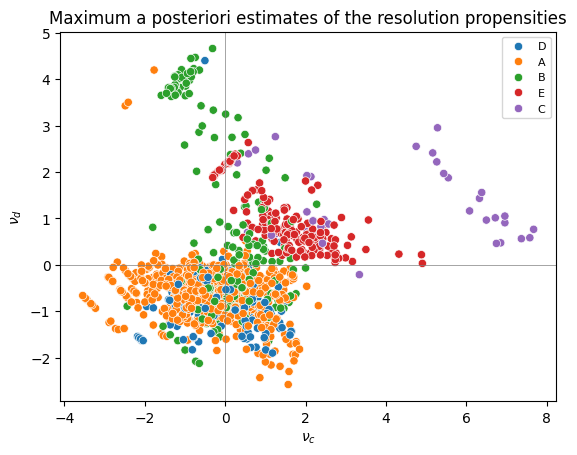

In [35]:
fig_nuCD(nu_c, nu_d, datafr, column_classes)

#### Observations:
- **$\nu_C$ (Global Propensity to Vote):**
    - Indicates the likelihood of a ballot being voted on (either positively or negatively).
- **$\nu_D$ (Supporter Alignment):**
    - Represents the degree to which a ballot gathers votes from its supporters.
- **Clusters:**
    - Upper-right cluster: High $\nu_C$ and $\nu_D$, showing high importance and strong support (topics C and E, proposed by the government).
    - Lower-left cluster: Low $\nu_C$ and $\nu_D$, indicating less importance or polarizing topics (topics A, B, D).

#### Key Insights:
- Ballots with strong governmental backing (C and E) gather more attention and positive votes.
- Opposition-proposed topics (A, D, B) struggle to gain widespread support.


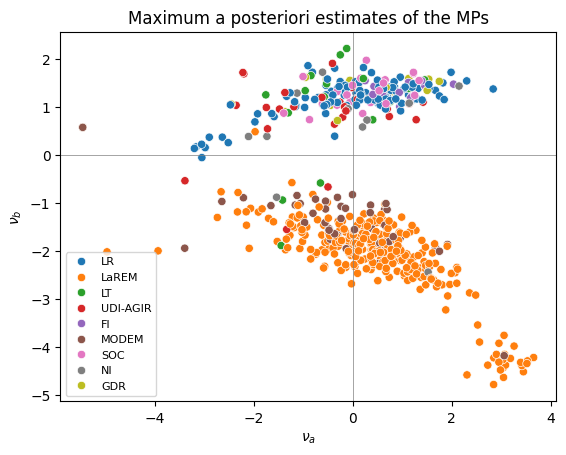

In [21]:
fig_nuAB(nu_a, nu_b, deputes)

#### Observations:
- **$\nu_A$ (Abstention Propensity):**
    - Indicates MPs' likelihood of abstaining or being absent.
- **$\nu_B$ (Voting Positively):**
    - Represents the likelihood of MPs voting positively.
- **Clusters:**
    - One cluster represents opposition MPs, who are more likely to vote when minority votes are critical.
    - The other cluster represents government MPs, who may abstain even on critical votes, as their majority ensures passage.

#### Key Insights:
- Opposition MPs are more active in critical votes, reflecting their strategic voting behavior.
- Government MPs rely on majority status, leading to higher abstention rates.


### Assessment of Results
The co-clustering results align well with political realities in the French Parliament. However, the premature stopping of the training due to numerical issues and random initialization impacted the model's performance.

#### Strengths:
- The MNAR (Missing Not At Random) missingness model effectively captures abstention and absence patterns.
- Clear clustering of MPs and ballots provides interpretable results.

#### Weaknesses:
- Limited model scope to binary data.
- Lack of identifiability proofs for model parameters.

---

#### Future Directions
- Extend the model to handle continuous or multi-level categorical data.
- Apply the model to other domains, such as recommendation systems, to analyze non-respondent behavior.
- Address theoretical gaps in parameter identifiability and consistency.

### Annex : In depth explanation of the training procedure

---

### Quasi-Newton Method

The LBFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) optimizer is a quasi-Newton method used to optimize the parameters of the model. It approximates the Hessian matrix of second derivatives to improve convergence while avoiding the computational cost of full Hessian calculations.

#### Update Rule
The quasi-Newton update iteratively refines the parameters $\theta$ to minimize the objective function $f(\theta)$ (negative log-likelihood in our case). At each step, the update is:
$$
\theta_{t+1} = \theta_t - \eta \mathbf{H}_t^{-1} \nabla f(\theta_t),
$$
where:
- $\nabla f(\theta_t)$ is the gradient of the objective function at step $t$.
- $\mathbf{H}_t^{-1}$ is the approximate inverse Hessian matrix at step $t$.
- $\eta$ is the learning rate, typically determined via line search.

#### LBFGS Approximation
Instead of storing the full Hessian matrix, LBFGS maintains a history of gradient and parameter updates to approximate the inverse Hessian:
$$
\mathbf{H}_t^{-1} \approx \mathbf{H}_{t-1}^{-1} + \frac{\mathbf{s}_t \mathbf{s}_t^\top}{\mathbf{s}_t^\top \mathbf{y}_t} - \frac{\mathbf{H}_{t-1} \mathbf{y}_t \mathbf{y}_t^\top \mathbf{H}_{t-1}}{\mathbf{y}_t^\top \mathbf{H}_{t-1} \mathbf{y}_t},
$$
where:
- $\mathbf{s}_t = \theta_t - \theta_{t-1}$ (parameter update).
- $\mathbf{y}_t = \nabla f(\theta_t) - \nabla f(\theta_{t-1})$ (gradient difference).

---

### Re-parameterization Function

Re-parameterization ensures numerical stability during optimization and restricts the model parameters to valid domains (e.g., probabilities between 0 and 1).

#### Transformations
1. **Softmax Transformation** (for mixture proportions $\alpha$ and $\beta$):
   - Converts unconstrained values $\tau$ into probabilities $\alpha_k$ and $\beta_l$ that sum to 1:
   $$
   \alpha_k = \frac{\exp(\tau_k)}{\sum_{k'} \exp(\tau_{k'})}, \quad \beta_l = \frac{\exp(\tau_l)}{\sum_{l'} \exp(\tau_{l'})}.
   $$

2. **Sigmoid Transformation** (for block probabilities $\pi_{kl}$):
   - Maps unconstrained values $\nu_{kl}$ to the range $[0, 1]$:
   $$
   \pi_{kl} = \frac{1}{1 + \exp(-\nu_{kl})}.
   $$

3. **Softplus Transformation** (for variance parameters $\sigma^2$):
   - Ensures positivity of variance terms:
   $$
   \sigma^2 = \log(1 + \exp(\rho)).
   $$

#### Purpose
- **Numerical Stability**: Prevents optimization issues like division by zero or invalid probabilities.
- **Interpretability**: Guarantees that learned parameters are in valid domains for their respective roles (e.g., probabilities sum to 1, variances are positive).

These transformations allow unconstrained optimization of parameters while enforcing constraints implicitly through the re-parameterized forms.